<a href="https://colab.research.google.com/github/takatakamanbou/ML/blob/2022/ex03noteB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML ex03noteB

<img width=72 src="https://www-tlab.math.ryukoku.ac.jp/~takataka/course/ML/ML-logo.png"> [この授業のウェブページ](https://www-tlab.math.ryukoku.ac.jp/wiki/?ML/2022)


----
## 準備
----

Google Colab の Notebook では， Python というプログラミング言語のコードを動かして計算したりグラフを描いたりできます．
Python は，機械学習・人工知能やデータサイエンスの分野ではメジャーなプログラミング言語ですが，それを学ぶことはこの授業の守備範囲ではありません．以下の所々に現れるプログラムっぽい記述の内容は，理解できなくて構いません．

以下，コードセルを上から順に実行してながら読んでいってね．

In [ ]:
# 準備あれこれ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
seaborn.set()

----
## 識別のための教師あり学習(1) 識別とは／最短距離法
----




----
### 復習 ― 回帰と識別


教師あり学習の問題は，出力の値がどのようなものであるかによって，次の二つに分けることができるのでした．

**回帰** (regression): 出力として量的な値を扱う場合．

**識別** (classification, **分類**とも): 入力をあらかじめ定めたいくつかのグループに分ける問題．

$$
\boldsymbol{y} \longleftarrow \fbox{$f$} \longleftarrow \boldsymbol{x} \qquad\qquad\qquad\qquad \boldsymbol{y} = f(\boldsymbol{x})
$$


「機械学習とは (1)」であげた例を教師あり学習の問題としてとらえると，次のように回帰／識別に分けられます．

#### やってみよう

以下の例がそれぞれ「回帰」「識別」のどちらの問題と考えられるか答えなさい．

**例1**: 手書き数字の認識 → 

- 入力: 手書き数字の画像
- 出力: 0, 1, 2, ..., 9 のいずれか

**例2**: 画像に写った動物を分類する → 

- 入力: 様々な動物の写った画像
- 出力: ネコ，ペンギン，カピバラ，..., のいずれか


**例3**: 電力使用量の予測 → 

- 入力: 時々刻々変化する気温，湿度，電力使用量の数値
- 出力: 1時間後の電力使用量の数値

**例4**: 顔画像からの年齢推定 → 

- 入力: 顔画像
- 出力: 年齢を表す数値

----
### 例題: 人間 vs ほげ星人

識別の問題について考える際の具体例として，「身長(cm)」と「体重(kg)」という二つの値から，「人間」と「ほげ星人」を識別する問題を考えます．



In [ ]:
# 「人間 vs ほげ星人」データの入手
dfHoge = pd.read_csv('https://www-tlab.math.ryukoku.ac.jp/~takataka/course/ML/humanvshoge.csv', header=0)

データの中身はこんなん：

In [ ]:
dfHoge

,height,weight,label
0,176.8,80.7,Human
1,169.4,41.1,Human
2,162.4,50.5,Human
3,106.7,82.8,Hoge
4,97.1,88.0,Hoge
...,...,...,...
195,105.5,100.9,Hoge
196,93.0,95.8,Hoge
197,201.8,96.1,Human
198,98.8,110.8,Hoge


1行がひとりぶんのデータ．'height' が身長，'weight'が体重，'label' が 'Human' なのは人間，'Hoge' なのはほげ星人，ということです．

In [ ]:
# 人間とほげ星人に分けて身長と体重のデータを抽出
X_human = dfHoge.loc[dfHoge['label'] == 'Human', ['height', 'weight']].to_numpy()
X_hoge  = dfHoge.loc[dfHoge['label'] != 'Human', ['height', 'weight']].to_numpy()
print(X_human.shape, X_hoge.shape)

(100, 2) (100, 2)


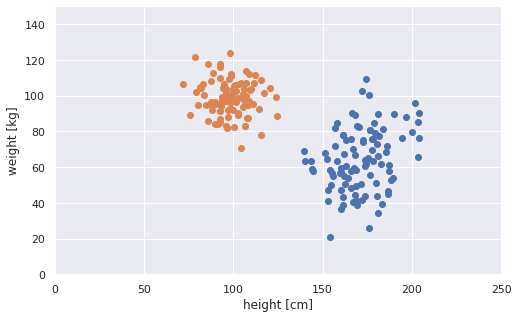

In [ ]:
# 身長を横軸に，体重を縦軸にとって散布図を描く
# 人間が青でほげ星人がオレンジ
fig, ax = plt.subplots(facecolor="white", figsize=(8, 8))
ax.set_xlim(0,250)
ax.set_xlabel('height [cm]')
ax.set_ylim(0,150)
ax.set_ylabel('weight [kg]')
ax.set_aspect('equal')
ax.scatter(X_human[:, 0], X_human[:, 1])
ax.scatter(X_hoge[:, 0], X_hoge[:, 1])
plt.show()

ひとりひとりが $(身長,体重)$ という二つの数値の組で表されていますので，これら二つの値で散布図を描いてみると，ひとりが一つの点に対応します．
図の青い点が人間，オレンジの点がほげ星人（注）．

<span style="font-size: 75%">
※注: ここで扱っているデータは，架空のものです．説明を簡単にするために身長や体重の値を適当に設定しています．例題としての扱いを超えて，「身長や体重の値が〇〇だと人間ではない」というような主張をしているわけではありません．
</span>

----
### 識別とは


回帰と識別ではモデルの出力の形式が異なります．回帰の場合は実数値を出力しますが，
識別の場合は，予め定めたグループのうちどれに分類されるかを表す情報を出力します．上記の例では，「人間」と「ほげ星人」のどちらかに分類することになります．

識別問題において，「人間」と「ほげ星人」のように予め定めた分類グループのことを，**クラス**(class) または **カテゴリ**(category) といいます．「人間 vs ほげ星人」の問題は，与えられた $(身長,体重)$ のデータから個々のひとを「人間」，「ほげ星人」という2クラスのいずれかに分類する問題です．

識別は，教師あり学習の問題の一種です．
「人間 vs ほげ星人」の例で言えば，下図左のように正解（「人間」か「ほげ星人」か）がわかっている学習データ（青とオレンジの点）が与えられたときに，これらを用いて，$(身長, 体重) = (x_1, x_2)$ のひとが「人間」か「ほげ星人」かを決める仕組みを作りたい，という話です．

典型的な識別の考え方は，学習データを用いて下図右のように入力データの空間（今の場合は2次元平面）をクラスごとの領域に分割する，というものです．このような考え方の場合，クラスを分ける境界（**識別境界**）を何らかの方法で決めることになります．

<img width="75%" src="https://www-tlab.math.ryukoku.ac.jp/~takataka/course/ML/humanvshoge3.png">

----
### 最短距離法

**最短距離法** は，最も単純な識別の手法です．これは，次のようなものです．

1. クラスごとに見本となるデータ（これを **プロトタイプ** (prototype）といいます）を用意しておく．
1. 所属クラスが未知のデータが与えられたら，そのデータがどのプロトタイプと近いかを調べる．
1. 一番近いプロトタイプと同じクラスに分類する．


以下に「人間 vs ほげ星人」の識別を最短距離法で行うプログラムを用意しました．
ここでは，「人間」のプロトタイプを $(170, 65)$ とし，「ほげ星人」のプロトタイプ $(100, 100)$ としています．
また，距離はユークリッド距離で測ることにしています．身長と体重の値をいろいろ代えて実験してみましょう．

ちなみに，ユークリッド距離というのは，みなさんが一番なじみのある距離です（注）．点 $(x_1, x_2)$ と点 $(y_1, y_2)$ の間の距離は，
$$
\sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2}
$$
ですね．

※注: 実は，「距離」にはユークリッド距離以外にも様々なものがあります．
詳しくは説明しませんが，機械学習の分野では，データや問題の性質に応じて，ユークリッド距離以外の距離を使うこともあります．

次のセルでは，実験のための関数を定義しています．関数を定義しているだけなので，このセルを実行しただけでは見た目上は何も起こりません．
続けてもう一つ下のセルも実行しましょう．

In [ ]:
# 「人間 vs ほげ星人」実験のための関数
#
def hoge(proto_human, proto_hoge, height, weight):

    # 識別対象の身長と体重
    x = np.array([height, weight])

    # 距離（の2乗）の計算
    v = x - proto_human
    d2_human = v @ v
    print(f'(人間のプロトタイプとの距離の2乗) = {d2_human}')
    v = x - proto_hoge
    d2_hoge  = v @ v
    print(f'(ほげ星人のプロトタイプとの距離の2乗) = {d2_hoge}')

    # 識別
    if d2_human <= d2_hoge:
        print(f'{d2_human} < {d2_hoge} なので， ({x[0]}, {x[1]}) のひとは「人間」に識別')
    else:
        print(f'{d2_human} > {d2_hoge} なので， ({x[0]}, {x[1]}) のひとは「ほげ星人」に識別')

    # グラフを描く
    fig, ax = plt.subplots(facecolor="white", figsize=(8, 8))
    ax.set_xlim(0,250)
    ax.set_xlabel('height [cm]')
    ax.set_ylim(0,150)
    ax.set_ylabel('weight [kg]')
    ax.set_aspect('equal')
    # 2つのプロトタイプと識別対象の点を打つ
    ax.plot(proto_human[0], proto_human[1], marker='o', markersize=10)
    ax.plot(proto_hoge[0], proto_hoge[1], marker='o', markersize=10)
    ax.plot(x[0], x[1], marker='*', markersize=16)
    # 識別対象の点とプロトタイプの間に破線を引く
    ax.plot([x[0], proto_human[0]], [x[1], proto_human[1]], linestyle='--', color='blue')
    ax.plot([x[0], proto_hoge[0]], [x[1], proto_hoge[1]], linestyle='--', color='orange')
    # 識別境界
    m = (proto_human + proto_hoge)/2 # 中点
    p = proto_human - proto_hoge
    xp = np.array([0, 250])
    yp = -p[0]*(xp - m[0])/p[1] + m[1]
    ax.plot(xp, yp, linestyle='-', color='gray')
    plt.show()

(人間のプロトタイプとの距離の2乗) = 225.0
(ほげ星人のプロトタイプとの距離の2乗) = 5300.0
225.0 < 5300.0 なので， (170.0, 80.0) のひとは「人間」に識別


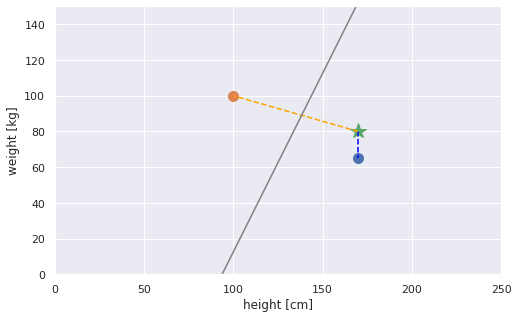

In [ ]:
#@title height，weightの値をいろいろ変えて実験しよう  {run: "auto"}
height = 170.0 #@param {type:"number"}
weight = 80.0 #@param {type:"number"}

# プロトタイプ
p_human = np.array([170.0,  65.0])
p_hoge  = np.array([100.0, 100.0])

# (height, weight) のひとはどっち？
hoge(p_human, p_hoge, height, weight)

最短距離法では，距離の大小を調べたいわけですが，平方根をとるのを省いても大小関係は変わりませんので，わざわざ平方根をとらず，距離の2乗の値の大小を調べるだけで済みます．
また，2つのクラスの識別境界は，両者のプロトタイプに関する垂直二等分線（3次元以上なら同じ性質をもつ平面）となります（グラフの灰色の直線）．

#### やってみよう
1. $(\textrm{height}, \textrm{weight})$ の値をいろいろ変えて上記のセルを実行し，結果を観察しよう．
1. 以下の二人は人間と識別されるかほげ星人と識別されるかセルを実行して確認しよう．
結果をノート等（紙媒体）にメモしておこう．
    - $(身長, 体重) = (135, 45)$ のひと
    - $(身長, 体重) = (135, 82)$ のひと



上記の実験ではプロトタイプを適当に決めているので，「学習」の要素が見当たりませんが，実際には例えば，学習データのクラスごとの平均を求めてそれをプロトタイプとする，というような方法をとることができます．


上では2次元平面上のユークリッド距離で説明していましたが，3次元以上のデータでも同じようにユークリッド距離を考えて最短距離法を用いることができます．
$D$ 次元空間中の点 $(x_1, x_2, \ldots, x_D)$ と点 $(y_1, y_2, \ldots, y_D)$ の間のユークリッド距離は
$$
\sqrt{\sum_{d=1}^{D}(x_d - y_d)^2}
$$
ですね（2次元の場合と同じく，実用的には平方根をとった距離の値ではなく距離の2乗の値を用いる方が計算の手間が少なくてよいですね）．

----
### 例題: 手書き数字の識別

0 から 9 までの手書き数字の画像から，その画像に写っている数がいくつかを答えさせる問題を考えます．

ここで扱うデータは，機械学習の分野で超有名な [MNIST](http://yann.lecun.com/exdb/mnist/) と呼ばれるデータセットからとったものです．
MNIST のデータは学習用だけで6万枚の画像がありますので，そこからランダムに一部の画像を抽出したものを用意しました．


In [ ]:
# 手書き数字データの入手
! wget -nc https://www-tlab.math.ryukoku.ac.jp/~takataka/course/ML/minimnist.npz
rv = np.load('minimnist.npz')
datL = rv['datL'].astype(float)
labL = rv['labL']
datT = rv['datT'].astype(float)
labT = rv['labT']
print(datL.shape, labL.shape, datT.shape, labT.shape)

File ‘minimnist.npz’ already there; not retrieving.

(5000, 784) (5000,) (1000, 784) (1000,)


以下のセルでは関数を定義しています．定義してるだけですので，このセルを実行しただけでは何も起こりません．

In [ ]:
# データを画像として表示するための関数
#
def display(data, nx, ny, nrow=28, ncol=28, gap=4):

    assert data.shape[0] == nx*ny
    assert data.shape[1] == nrow*ncol

    # 並べた画像の幅と高さ
    width  = nx * (ncol + gap) + gap
    height = ny * (nrow + gap) + gap

    # 画像の作成
    img = np.zeros((height, width), dtype = int) + 128
    for iy in range(ny):
        lty = iy*(nrow + gap) + gap
        for ix in range(nx):
            ltx = ix*(ncol + gap) + gap
            img[lty:lty+nrow, ltx:ltx+ncol] = data[iy*nx+ix].reshape((nrow, ncol))

    # 画像の出力
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')
    plt.show()

学習データ中の最初の50個の画像を表示．

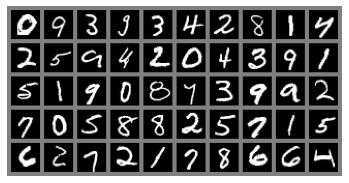

In [ ]:
nx, ny = 10, 5
display(datL[:50], nx, ny)

それぞれの正解クラスを表示．

In [ ]:
for iy in range(ny):
    print(labL[iy*nx:(iy+1)*nx])

[0 9 3 9 3 4 2 8 1 4]
[2 5 9 4 2 0 4 3 9 1]
[5 1 9 0 8 7 3 9 9 2]
[7 0 5 8 8 2 5 7 1 5]
[6 2 7 2 1 7 8 6 6 4]


このデータの画像は，幅28画素高さ28画素の8bitグレイスケール画像です．一つの画素の値は 0 から 255 までの整数値をとります．
したがって，一つの画像は $28\times 28 = 784$ 個の値をもつ $784$ 次元のデータとみなすことができます．

In [ ]:
# 最初のデータの値を表示してみる
for iy in range(28):
    for ix in range(28):
        val = int(datL[0, iy*28+ix])
        print(f'{val:0>3}', end=' ')  # 見やすさのため 0 を付けてすべて3桁で
    print()

000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 142 254 254 254 254 141 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 217 248 252 253 253 253 253 252 228 042 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 094 252 253 253 253 253 253 253 253 253 246 149 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 044 229 253 253 253 253 253 253 253 253 253 253 238 043 000 000 000 000 000 
000 000 000 000 000 000 000 000 043 229 253 253 253 253 253 203 253 253 203 253 253 253 228 043 

----
### 最短距離法による手書き数字の識別

上記のデータに対して最短距離法を適用して識別させてみましょう．
クラスごとのプロトタイプには，学習データの平均を用いることにします．

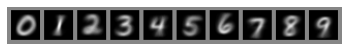

In [ ]:
K = 10 # クラス数
D = 784 # データの次元数

# 学習データのクラスごとの平均をプロトタイプとする
proto = np.empty((K, D)) # プロトタイプ
for ik in range(K):
    proto[ik, :] = np.mean(datL[labL == ik, :], axis=0)

display(proto, K, 1)

まずは，学習データを識別させてみます．

In [ ]:
# 学習データを識別
N = len(datL)
ncorrect = 0
for n in range(N):
    dist2 = np.sum((datL[n, :] - proto)**2, axis=1) # 各プロトタイプとの距離の2乗
    out = np.argmin(dist2)  # 距離最小のプロトタイプの番号
    if out == labL[n]:     # 正解数をカウント
        ncorrect += 1

print(f'{ncorrect}/{N} = {ncorrect/N}')

4009/5000 = 0.8018


5000個の学習データのうち4009個で正解したということで，その割合はおよそ 0.8 となりました．この割合のことを「識別率」といいます．

次は，学習データとは別に用意したデータを識別させてみます．

In [ ]:
# 別に用意したデータを識別
N = len(datT)
out = np.empty(N, dtype=int)
for n in range(N):
    dist2 = np.sum((datT[n, :] - proto)**2, axis=1) # 各プロトタイプとの距離の2乗
    out[n] = np.argmin(dist2)  # 距離最小のプロトタイプの番号

ncorrect = np.sum(out == labT) # 正解数をカウント

print(f'{ncorrect}/{N} = {ncorrect/N}')

819/1000 = 0.819


こちらの識別率は 81.9% となりました．試しに最初の方のデータを可視化してみましょう．

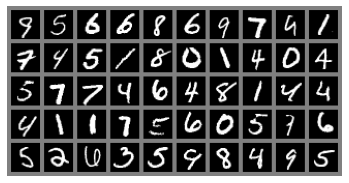

In [ ]:
nx, ny = 10, 5
display(datT[:50], nx, ny)

識別結果（どの数と判断したか）はこんなん：

In [ ]:
for iy in range(ny):
    print(out[iy*nx:(iy+1)*nx])

[9 5 6 6 8 6 9 7 4 1]
[9 4 5 1 8 0 5 9 0 9]
[5 7 7 4 6 4 8 1 4 4]
[4 1 1 7 5 6 0 5 1 6]
[5 2 5 3 3 9 8 4 9 5]


それぞれの正解はこんなん：

In [ ]:
for iy in range(ny):
    print(labT[iy*nx:(iy+1)*nx])

[9 5 6 6 8 6 9 7 9 1]
[7 4 5 1 8 0 1 4 0 4]
[5 7 7 4 6 4 8 1 4 4]
[4 1 1 7 5 6 0 5 7 6]
[5 2 6 3 5 9 8 4 9 5]
